In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Importing the libraries 
import torch
import torchaudio
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import matplotlib.cm as cm
import pandas as pd
import os
import librosa
import librosa.display
import torch.nn.functional as F
from torch.autograd import Variable
import time
# from Models import Autoencoder
# from TestData import SingleMus
from Data_TIMIT import Data_TIMIT
import IPython.display as ipd
from IPython.display import clear_output
from Blocks import BasicBlock, Bottleneck, ChannelChange
# from EntropyControl_curr import AE_control
# from EntropyControl_curr import AE_control
from Prop_nonSR import Prop_Model

# Checking the availability of CUDA on machine
# print("Torch", torch.__version__, "CUDA", torch.version.cuda)
# print("Device:", torch.device("cuda:3"))
# print(torch.cuda.is_available())



/media/sdb1/hy17/venv/lib/python3.6/site-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


## Data Preparation

- #### TIMIT Data

In [2]:
# overlap = 64
# data = Data_TIMIT('test', overlap = overlap)
# test_loader = torch.utils.data.DataLoader(data, batch_size = 1, shuffle \
#                                            = True, num_workers = 4)
# torch.save(test_loader, 'data/half_win_test_mul.pth')

In [3]:
# data = Data_TIMIT('train', mix_num = 1)
# train_loader = torch.utils.data.DataLoader(data, batch_size = 50, shuffle \
#                                            = True, num_workers = 4)
# torch.save(train_loader, 'data/half_win_train_mul.pth')

In [4]:
train_path = 'data/half_win_train_ctn_std4_m.pth'
test_path = 'data/half_win_test_ctn_std4_m.pth'
train_loader = torch.load(train_path)
test_loader = torch.load(test_path)

In [5]:
print(len(train_loader),len(test_loader))

3000 300


In [6]:
# for c, x, c_l, x_l in test_loader:
#     break
# print(c.shape)
# print(x.shape)
# print(c_l.shape)
# print(x_l.shape)

In [7]:
# ipd.Audio(rebuild(mixture[0].cpu().data.numpy()), rate = 16000)

In [8]:
# SISDR(source, mixture)

#### Dummy testing, for easy running

Test on whole wavefiles - able to be rebuild

In [9]:

def SISDR(s,sr,  cuda = False):
    
    eps = 1e-20
    scale = torch.sum(sr * s, dim = 1) / torch.sum(s**2, dim = 1) 
    scale = scale.unsqueeze(dim = 1) # shape - [50,1]
    s = s * scale
    sisdr = torch.mean(10*torch.log10(torch.sum(s**2, dim = 1)/(torch.sum((s-sr)**2, dim=1)+eps)+eps))
    if cuda:
        return torch.mean(sisdr)
    else:
        return torch.mean(sisdr).cpu().data.numpy()

def SDR(s, sr, cuda = False): # input (50, 512), (50, 512)
    
    eps=1e-20
    sdr = torch.mean(10*torch.log10(torch.sum(s**2, dim = 1)/(torch.sum((s-sr)**2, dim=1)+eps)+eps))
    
    if cuda:
        return sdr
    else:
        return sdr.cpu().data.numpy()

def melMSELoss(s, sr): # input waveform(torch.Tensor)
    
    n_mels = [8, 16, 32, 128]
    loss = 0
    eps = 1e-20
    mse = nn.MSELoss()
    for n in n_mels:
        s_mel = torchaudio.transforms.MelSpectrogram(n_fft=512, n_mels=n)(s)
        sr_mel = torchaudio.transforms.MelSpectrogram(n_fft=512, n_mels=n)(sr)
        s_mel = torch.log(s_mel + eps)
        sr_mel = torch.log(sr_mel + eps)
        m = mse(s_mel, sr_mel)
        loss += m
    return loss/len(n_mels)    

def rebuild(output, overlap = 64):
    output = output.cpu()
    len_wav = len(output) * (512 - overlap) + overlap
    wave = torch.zeros(len_wav)
    for i in range(len(output)):
#         print(i)
        wave[i*(512-overlap):i*(512-overlap)+512] += output[i]       
    
    return wave

def test_newData(soft):
#     model.eval()
    sdr_list_s = []
#     sdr_list_n = []
    sdr_list_rs = []
    sdr_list_rx = []
    sdr_list_diff = []
    max_rs_sdr = 0
    max_rx_sdr = 0
    max_rs = None
    max_rx = None

    i = 0
    for wave_s, wave_x, source, mixture in test_loader: 

        source = source[0]
        mixture = mixture[0]
#         print(data)
        noise = (mixture-source).cuda()
        source = source.cuda()
        mixture = mixture.cuda()
        s_h, n_h, arg_s, arg_n = model(mixture, soft=soft)
        
        sdr_list_s.append(SISDR(source, s_h))    
#         sdr_list_n.append(SISDR(noise, n_h))
        
        rs = rebuild(s_h).unsqueeze(dim = 0)
        rn = rebuild(n_h).unsqueeze(dim = 0)
        
        rs_sdr = SISDR(wave_s, rs)
        rx_sdr = SISDR(wave_x, rs+rn)
        sdr_list_rs.append(rs_sdr)
        sdr_list_rx.append(rx_sdr)
        
        start_sdr = SISDR(wave_s, wave_x/max(wave_x[0]))
        sdr_list_diff.append(rs_sdr-start_sdr)
        
        if max_rs_sdr < rs_sdr:
            max_rs_sdr = rs_sdr
            max_rs = (wave_x, rs, rn)
#         if max_rx_sdr < rx_sdr:
#             max_rx_sdr = rx_sdr
#             max_rx = (rs, rn)
         
    
    s_score = np.mean(sdr_list_s) 
#     n_score = np.mean(sdr_list_n)
    rs_score = np.mean(sdr_list_rs)
    rx_score = np.mean(sdr_list_rx)
    diff_score = np.mean(sdr_list_diff)
    
    return s_score, rs_score, rx_score, diff_score, max_rs, arg_s, arg_n


import collections

def cal_entropy(arg):
    
    entropy = 0
    counter = collections.Counter(arg)
    sum_v = sum(counter.values())
    for value in counter.values():
        p = value / sum_v
        entropy += - np.log(p)*p
        
    return entropy


def entropy_prob(prob): # prob (bs, 512, num_m)
    
    entropy = 0
    eps = 1e-20
    prob_counter = torch.sum(prob, dim=0)
    prob_counter = torch.sum(prob_counter, dim=0)
    assert len(prob_counter) == prob.shape[-1]
    prob_counter = prob_counter / sum(prob_counter)
    entropy = - torch.sum(torch.log(prob_counter+eps)*prob_counter)
#     sum_v = sum(prob_counter)
#     for value in prob_counter:
#         p = value / sum_v
#         entropy += -torch.log(p+eps)*p
    
    return entropy

## Model Define

In [10]:
if train_path == 'data/half_win_train_ctn_std4_m.pth':
    db = '_5db'
else:
    db = '_0db'
filters = 30
d = 6
f2 = 60
m = 160
sr = False
lr = 0.0001
weight1 = 1/5
weight2 = 1/60
weight = 1/20
target_clean = 1.25
target_noise = 0.75
target = 4
ratio = 1/2.5
label = time.strftime("%m%d_%H%M%S")
model_name = label+'_16_d'+str(d)+db

In [11]:
# hypara = '({}, {}, {}, {}, {}({},{:.2f}), {}, {}) - {} '\
#       .format(filters, d, f2, m, sr, target, ratio, str(weight1)[:5], str(weight2)[:5],\
#              model_name)
# print(hypara)

In [12]:
hypara = '({}, {}, {}, {}, {}({},{}), {}) - {} '\
      .format(filters, d, f2, m, sr, target_clean, target_noise, weight,\
             model_name)
print(hypara)

(30, 6, 60, 160, False(1.25,0.75), 0.05) - 0616_205028_16_d6_5db 


In [13]:
model = Prop_Model(block = Bottleneck, scale = 10, filters = filters, d_s = d, d_n = d,\
                   f2 = f2, num_m = m, sr = sr, ratio = ratio).cuda()
# model = torch.load('0609_214801_srFalse40.0_d6_5db.model')
# print(model.code.is_leaf)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(list(model.parameters()) + [model.means_s] + [model.means_n] \
                             + [model.ratio], lr=lr)
t = 0
# #                              ,betas = (0.9, 0.99999))
# optimizer = torch.optim.Adam(list(model.parameters()) , lr=lr) \
#                              ,betas = (0.9, 0.99999))
#                              weight_decay=1e-5)
# target_clean = target * model.ratio
# target_noise = target * (1-model.ratio)

Bottleneck


## Train

In [14]:
epochs = 50
epoch_list = []
max_sdr = (0,0,0,0)
max_rs = None
flct = 0.1
etp = 0
itermax = 0
# model.stage = 1

In [15]:
# itermax = 0
# max_sdr = (0,0,0,0)
# etp = 0
while 1: 
    start = time.time()
    model.train()
    if t == 3:
        model.stage = 1
    if model.scale < 500:
        model.scale *= t+1
    train_sdr_s = []
    train_sdr_rs = []
    train_sdr_rx = []
    
    train_etp_cl = []
    train_etp_ns = []
    control = 0
    
    for wave_s, wave_x, source, mixture in train_loader:
        
        source = source[0]
        mixture = mixture[0]
        
        noise = (mixture - source).cuda()
        source = source.cuda()
        mixture = mixture.cuda()

        s_h, n_h, prob_s, prob_n = model(mixture, soft = True)
        
#         train_sdr_s.append(SDR(s_h, source))
#         rs = rebuild(s_h).unsqueeze(dim = 0)
#         train_sdr_rs.append(SISDR(wave_s, rs))
#         rn = rebuild(n_h).unsqueeze(dim = 0)
#         train_sdr_rx.append(SISDR(wave_x, rn+rs))
#         train_mel = melMSELoss(wave_s, rs)
        
        entp_cl = None
        entp_ns = None
        if not isinstance(prob_s, type(None)) and not isinstance(prob_n, type(None)):
            entp_cl = entropy_prob(prob_s)
            train_etp_cl.append(entp_cl.cpu().data.numpy())
            entp_ns = entropy_prob(prob_n)
            train_etp_ns.append(entp_ns.cpu().data.numpy())    
            
#         if model.stage == 1:
        loss = criterion(s_h, source) + criterion(n_h+s_h, mixture)
#     + 1/100 * train_mel.cuda()
#             - SDR(wave_s, rs, cuda = True) - 1/10*SDR(wave_x, rs+rn, cuda = True)\
# #             + 1/50 * train_mel
# #             - SDR(wave_x-wave_s, rn, cuda = True)\
           
#         else:
#             loss = - SDR(wave_s, rs, cuda = True) - 1/10*SDR(wave_x, rs+rn, cuda = True) \
# #             + 1/50 * train_mel  
# #             - SDR(wave_x-wave_s, rn, cuda = True)
        
        if etp == 1:
#             control = 1
#             loss += weight1 * ((target - entp_cl - entp_ns)**2) + \
#                     weight2 * ((ratio - entp_ns/entp_cl)**2)
            
            if abs(target_clean - entp_cl) > flct:
#                 print('c1')
                control  = 1
                loss += weight * ((target_clean - entp_cl) ** 2)
            if abs(target_noise - entp_ns) > flct:
#                 print('c2')
                control = 1
                loss += weight * ((target_noise - entp_ns) ** 2)
        
#         if etp == 1:
#             if abs(target - entp_cl - entp_ns) > flct:
#                 control = 1
#                 loss += 1/2 * ((target - entp_cl - entp_ns) ** 2).cpu()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    end = time.time()
    print('epoch_{}| Time:{:.0f} | Control:{:.0f} | Stage: {} | Itermax: {} | etp:{} '\
          .format(t, end-start, control, model.stage, itermax, etp))

#     s_s_score, s_rs_score, s_rx_score, s_diff_score, _, _, _ = test_newData(True)
    h_s_score, h_rs_score, h_rx_score, h_diff_score, max_single_rs,  arg_s, arg_n = test_newData(False)
    
    entropy = [0, 0]

    if not isinstance(arg_s, type(None)):
        entropy[0] = cal_entropy(arg_s.data.cpu().numpy().flatten())
    if not isinstance(arg_n, type(None)):
        entropy[1] = cal_entropy(arg_n.data.cpu().numpy().flatten())
      
    epoch_list.append((h_s_score, h_rs_score, h_diff_score, entropy[0]))
    print('|Test-hard s: {:.2f}, rs: {:.2f}, rx: {:.2f}, diff: {:.2f} \n\
          |Entropy : {:.2f}, {:.2f}'\
          .format(h_s_score, h_rs_score, h_rx_score, h_diff_score, 
                  entropy[0], entropy[1]))
 #          |Test-soft s: {:.2f}, rs: {:.2f}, rx: {:.2f}, diff: {:.2f} \n\
    
    t += 1
    if model.stage >= 1:
        itermax += 1
        if h_rx_score > max_sdr[1]:
            max_sdr = (h_rs_score, h_rx_score, entropy[0], entropy[1])
            max_rs = max_single_rs
            torch.save(model, model_name+'.model')  
            itermax = 0
    
    if model.stage == 1 and etp == 0 and itermax >= 3:
        etp = 1
        itermax = 0
        max_sdr = (0,0,0,0)

# #     if model.stage == 1 and itermax >= 2:
#     if model.stage == 1 and etp == 1 and itermax >= 3:
#         model.stage = 2  
#         itermax = 0
# #         max_sdr = (0,0,0,0)
#         print('Enter stage 2')

    if etp == 1 and itermax > 10:
        print('over')
        break


epoch_0| Time:177 | Control:0 | Stage: 0 | Itermax: 0 | etp:0 
|Test-hard s: -3.95, rs: 8.93, rx: 12.19, diff: 2.89 
          |Entropy : 0.00, 0.00
epoch_1| Time:131 | Control:0 | Stage: 0 | Itermax: 0 | etp:0 
|Test-hard s: -0.58, rs: 10.14, rx: 17.11, diff: 4.10 
          |Entropy : 0.00, 0.00
epoch_2| Time:146 | Control:0 | Stage: 0 | Itermax: 0 | etp:0 
|Test-hard s: -0.00, rs: 10.90, rx: 19.52, diff: 4.87 
          |Entropy : 0.00, 0.00
epoch_3| Time:271 | Control:0 | Stage: 1 | Itermax: 0 | etp:0 
|Test-hard s: -1.27, rs: 10.48, rx: 14.74, diff: 4.44 
          |Entropy : 2.13, 1.11
epoch_4| Time:367 | Control:0 | Stage: 1 | Itermax: 0 | etp:0 
|Test-hard s: 0.40, rs: 11.08, rx: 16.76, diff: 5.04 
          |Entropy : 2.78, 1.65
epoch_5| Time:336 | Control:0 | Stage: 1 | Itermax: 0 | etp:0 
|Test-hard s: 0.17, rs: 11.46, rx: 17.31, diff: 5.42 
          |Entropy : 2.69, 1.56
epoch_6| Time:304 | Control:0 | Stage: 1 | Itermax: 0 | etp:0 
|Test-hard s: 0.05, rs: 11.52, rx: 16.71

In [ ]:
# # model_name = model_name+str(max_sdr[1])[:5]
# output = '({}, {}, {}, {}, {}({},{:.2f}), {}, {}) - {}-({:.2f},{:.2f})({:.2f},{:.2f}) '\
#       .format(filters, d, f2, m, sr, target, ratio, str(weight1)[:5], str(weight2)[:5],\
#              model_name, max_sdr[0], max_sdr[1], max_sdr[2], max_sdr[3])
# print(output)
# with open('output_result.txt', 'a') as the_file:
#     the_file.write(output+'\n')

In [16]:
# model_name = model_name+str(max_sdr[1])[:5]
output = '({}-({:.2f},{:.2f})({:.2f},{:.2f}) '\
      .format(hypara, max_sdr[0], max_sdr[1], max_sdr[2], max_sdr[3])
print(output)
# with open('output_result.txt', 'a') as the_file:
#     the_file.write(output+'\n')

((30, 6, 60, 160, False(1.25,0.75), 0.05) - 0616_205028_16_d6_5db -(7.29,8.73)(1.11,0.60) 


In [ ]:
hypara = '({}, {}, {}, {}, {}({},{}), {}) - {}-({:.2f},{:.2f})({:.2f},{:.2f})  '\
      .format(filters, d, f2, m, sr, target_clean, target_noise, weight,\
             model_name)
print(hypara)

In [ ]:
rs = max_rs[1].cpu().data.numpy()[0]
rx = max_rs[1].cpu().data.numpy()[0]+max_rs[2].cpu().data.numpy()[0]
librosa.output.write_wav(model_name+'_rs.wav', rs/max(rs), sr = 16000)
librosa.output.write_wav(model_name+'_rx.wav', rx/max(rx), sr = 16000)

In [ ]:
ipd.Audio(max_rs[0].cpu().data.numpy(), rate = 16000)
# librosa.output.write_wav(model, save_max_rs_1[0].cpu().data.numpy()[0], sr = 16000)

In [ ]:
ipd.Audio(rs/max(rs), rate = 16000)
# librosa.output.write_wav('0508_whole_sp32_1392rs.wav', rs/max(rs), sr = 16000)

In [ ]:
ipd.Audio(rx/max(rx), rate = 16000)
# librosa.output.write_wav('0508_whole_sp32_1392rx.wav', rx/max(rx), sr = 16000)

## Train

In [ ]:
def get_n_params(model):
    count = 0
    for param in list(model.parameters()):
        nn = 1
        for s in list(param.size()):
            nn = nn*s
        count += nn
    return count
get_n_params(model)

In [ ]:
itermax

In [17]:
x = torch.Tensor(0).cuda()
x.cpu()

tensor([])

In [1]:
max_sdr

NameError: name 'max_sdr' is not defined

In [24]:
# torch.save(model, '0423_a4_full.model') 

In [34]:
# model = torch.load('0404_coding_test.model')

In [39]:
ipd.Audio('SAVED_RESULT/0329longtarget23_32r.wav', rate=16000)

In [13]:
ipd.Audio(max_rs[0].cpu().data.numpy()[0], rate = 16000)
# librosa.output.write_wav('0423_a4_19_12rs.wav', max_rs[0].cpu().data.numpy()[0], sr = 16000)

In [15]:
ipd.Audio((max_rs[1]+max_rs[2]).cpu().data.numpy()[0], rate = 16000)
# librosa.output.write_wav('0423_a4_20_15rx.wav', (max_rs[0]+max_rs[1]).cpu().data.numpy()[0], sr = 16000)

In [16]:
ipd.Audio(max_rs[1].cpu().data.numpy()[0], rate = 16000)
# librosa.output.write_wav('0326noMask11_6r.wav', max_rs.cpu().data.numpy()[0], sr = 16000)

In [ ]:
criterion(outputs, data)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(arg.data.cpu().numpy().flatten())

## Test

Test methods on truncated data

In [ ]:

def SISDR(s,sr,  cuda = False):
    
    eps = 1e-20
    scale = torch.sum(sr * s, dim = 1) / torch.sum(s**2, dim = 1) 
    scale = scale.unsqueeze(dim = 1) # shape - [50,1]
    s = s * scale
    sisdr = torch.mean(10*torch.log10(torch.sum(s**2, dim = 1)/(torch.sum((s-sr)**2, dim=1)+eps)+eps))
    if cuda:
        return torch.mean(sisdr)
    else:
        return torch.mean(sisdr).cpu().data.numpy()

def SDR(s, sr, cuda = False): # input (50, 512), (50, 512)
    
    eps=1e-20
    sdr = torch.mean(10*torch.log10(torch.sum(s**2, dim = 1)/(torch.sum((s-sr)**2, dim=1)+eps)+eps))
    
    if cuda:
        return sdr
    else:
        return sdr.cpu().data.numpy()


def rebuild(output, overlap = overlap):
    len_wav = len(output) * (512 - overlap) + overlap
    wave = np.zeros(len_wav)
    for i in range(len(output)):
#         print(i)
        wave[i*(512-overlap):i*(512-overlap)+512] += output[i]       
    
    return wave

def test_qtz(soft):
#     model.eval()
    sdr_list_s = []
    sdr_list_n = []
    i = 0

    for source, mixture in test_loader:
#         print(data)
#         print(i)
#         i+=1
        noise = (mixture-source).cuda()
        source = source.cuda()
        mixture = mixture.cuda()
        target = source
        
        s_h, n_h, arg_s, arg_n = model(mixture, soft)
        # arg will be None when doing softquantization

        sdr_list_s.append(SDR(noise, n_h))
        sdr_list_n.append(SDR(source, s_h))
        
    s_score = np.mean(sdr_list_s) 
    n_score = np.mean(sdr_list_n) 
    
    return s_score, n_score, arg_s, arg_n


def test_no_qtz():
#     model.eval()
    sdr_list_s = []
    sdr_list_n = []
    i = 0
    for source, mixture in test_loader:

#         print(data)
        noise = (mixture-source).cuda()
        source = source.cuda()
        mixture = mixture.cuda()
        s_h, n_h = model.test_no_qtz(mixture)
#         print(outputs)

        sdr_list_s.append(SDR(noise, n_h))
        sdr_list_n.append(SDR(source, s_h))
    
    s_score = np.mean(sdr_list_s) 
    n_score = np.mean(sdr_list_n)
    
    return s_score, n_score


import collections

def cal_entropy(arg):
    
    entropy = 0
    counter = collections.Counter(arg)
    sum_v = sum(counter.values())
    for value in counter.values():
        p = value / sum_v
        entropy += - np.log(p)*p
        
    return entropy

In [ ]:
# path = '/media/sdc1/Data/ETRI_Music/'
# test_data = SingleMus(path)
# bs = 50
# test_loader = torch.utils.data.DataLoader(test_data, batch_size = bs, shuffle \
#                                          = True, num_workers = 4)
# torch.save(test_loader, 'mus_test_dataloader.pth')

In [ ]:
# test_loader = torch.load('mus_test_dataloader.pth')

In [ ]:
# model = Autoencoder().cuda()
# model.load_state_dict(torch.load('0217_initiate.model'))

## Listenning Test

In [12]:
def trim(c):

    trim_len = int((len(c)//512)*512)
    c = c[:trim_len].reshape(-1, 512)

    return c

def rebuild(output):
    output = output.data.cpu().numpy()
    output = output.flatten()
    
    return output

def SDR(s, sr): # input (50, 512), (50, 512)
    
    eps=1e-20
    s = s.cpu().data.numpy()
    sr = sr.cpu().data.numpy()
    sdr = 10*np.log10(np.sum(s**2)/(np.sum((s-sr)**2)+eps)+eps)
    
    return sdr

In [13]:
# Compute entropy
import collections
def entropy(arg):
    entropy = 0
    counter = collections.Counter(arg)
    sum_v = sum(counter.values())
    for value in counter.values():
        p = value / sum_v
        entropy += - np.log(p)*p
    return entropy
    
# entropy(x)    

(array([1., 0., 1., 0., 0., 1., 0., 0., 0., 9.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

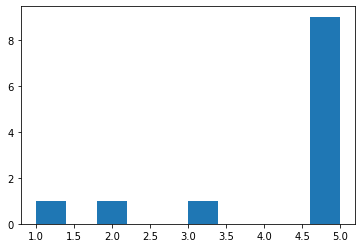

In [14]:
x = [1,2,3,5,5,5,5,5,5,5,5,5]
plt.hist(x)

In [66]:
import IPython.display
import matplotlib.pyplot as plt
wavpath1 = '/media/sdc1/Data/timit-wav/train/dr1/fcjf0/sa1.wav'
wavpath2 = '/media/sdc1/Data/timit-wav/train/dr1/fcjf0/sa2.wav'
c1, cr = librosa.load(wavpath1, sr=None)
c1 = c1/max(c1)
idx = 1
names = ['birds', 'computerkeyboard', 'jungle', 'ocean', 'casino', 'eatingchips', 'machineguns',\
                 'cicadas', 'frogs', 'motorcycles']
noise_path = '/media/sdc1/Data/Duan/{}.wav'.format(names[idx])
n, nr = librosa.load(noise_path, sr=None)
n = n/max(n)
# c2, cr = librosa.load(wavpath2, sr=None)
# c1_, cr = librosa.load(wavpath1)
# c1, c2 = c1/np.max(c1), c2/np.max(c2)
n = n[len(n)//2:len(n)//2+len(c1)]
mixture = n + c1

In [67]:
# mixture = 0.1 * n[len(n)//2:len(n)//2+len(c1)] + c1

In [68]:
IPython.display.Audio(mixture, rate = cr)

In [69]:
# # model = Autoencoder(block = Bottleneck,d = 15, num_m = 32, soft = True).cuda()
# model = torch.load('0304_entropy_control.model')

In [70]:
model.eval()
data = torch.Tensor(trim(mixture)).cuda()
clean = torch.Tensor(trim(c1)).cuda()
s_h, n_h, arg_s, arg_n = model(data, soft = False)

In [1]:
noise = torch.Tensor(trim(n)).cuda()
SDR(clean, n_h)

NameError: name 'torch' is not defined

In [57]:
data = torch.Tensor(trim(mixture)).cuda()
clean = torch.Tensor(trim(c1)).cuda()

In [53]:
dist = arg_n.data.cpu().numpy().flatten()
entropy(dist)

AttributeError: 'NoneType' object has no attribute 'data'

In [54]:
# IPython.display.Audio(mixture, rate = cr)

In [74]:
IPython.display.Audio(rebuild(n_h), rate = cr)

In [ ]:
data = torch.Tensor(trim(c1[:length])).cuda()
output1, arg1 = model.test_hard_qtz(data)
data = torch.Tensor(trim(c2[:length])).cuda()
output2, arg2 = model.test_hard_qtz(data)

In [ ]:
IPython.display.Audio(rebuild(output1)/max(c1)+rebuild(output2)/max(c2), rate = cr)

In [ ]:
muspath1 = '/media/sdc1/Data/ETRI_Music/1349-00002-RFO.wav'
m1, mr = librosa.load(muspath1)

In [ ]:
plt.plot(m1)

In [ ]:
dist1 = arg1.data.cpu().numpy().flatten()
dist2 = arg2.data.cpu().numpy().flatten()
dist_stk = np.hstack((dist1, dist2))

In [ ]:
dist_stk.shape

In [ ]:
print(entropy(dist1), entropy(dist2), entropy(dist), entropy(dist_stk))

In [ ]:
entropy(arg)

In [ ]:
x.reshape(-1, 3)